# PA4 - DPO

### Introduction

In this notebook, you will learn how to apply DPO to the SmolLM model you implemented in PA2. Before starting working on this notebook, please make sure to go through the README.md provided as it will intoduce to the concepts relevant to the assignment.


### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Read the Submission Instructions, Plagiarism Policy, and Late Days Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span>

- <span style="color: red;">You must attempt all parts.</span>

## Setup

### Imports

In [4]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)
Using cached huggingface_hub-0.30.2-py3-none-any.whl (481 kB)
Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl (2.4 MB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.25.1
    Uninstalling huggingface-hub-0.25.1:
      Successfully uninstalled huggingface-hub-0.25.1



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# For tokenization and dataset loading
from transformers import AutoTokenizer
from datasets import load_dataset

In [2]:
torch.manual_seed(42)

### Initializing device here for future use if needed

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## SmolLM Code

As in PA3, you will be using the smolLM model implemented in PA2.

#### The implementation for the SmolLM model from PA2 has been added below for your convenience. You just need to run the next 5 cells in order to define our model.

In [47]:
from dataclasses import dataclass

@dataclass 
class smolConfig:
    vocab_size = 49152
    hidden_size = 576
    intermediate_size = 1536
    num_hidden_layers = 30
    num_heads = 9
    kv_heads = 3

In [48]:
def rotate_half(x):
    """
    Helper function to rotate the left half of a tensor along its final dimension.
    """
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]

    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """
    Applies RoPE on the query and key tensors.
    """
    cos, sin = cos.to(q.device), sin.to(q.device)

    # Unsqueexzing to enable broadcasting
    sin = sin.unsqueeze(unsqueeze_dim)
    cos = cos.unsqueeze(unsqueeze_dim)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    
    return q_embed, k_embed

class RotaryEmbedder(nn.Module):
    def __init__(self, dim, base):
        super().__init__()
        # Precompute frequency for sine/cosine embeddings
        self.freq = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))

    @torch.no_grad()
    def forward(self, x):
        # Generate positions (sequence indices) for the input
        pos = torch.arange(x.shape[-2], dtype=torch.long)
        # Compute angles for sine and cosine embeddings
        angles = torch.einsum("p,f->pf", pos.float(), self.freq).unsqueeze(dim=0)
        # Duplicate angles for sine and cosine embeddings
        emb = torch.cat((angles, angles), dim=-1)
        # Return cosine and sine components of the positional embeddings
        return emb.cos(), emb.sin()

class GroupedQueryAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Model dimensions and attention configurations
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        self.head_dim = config.hidden_size // self.num_heads
        self.kv_heads = config.kv_heads  # Number of key-value heads
        self.rope_theta = 10000.0  # Scaling factor for rotary embeddings

        # Linear projections for queries, keys, values, and output
        self.q_proj = nn.Linear(config.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(config.hidden_size, config.hidden_size, bias=False)

        # Rotary embedding generator
        self.rotary_emb = RotaryEmbedder(base=self.rope_theta, dim=self.head_dim)

    def _repeat_kv(self, x, n_rep):
        batch, num_key_value_heads, slen, head_dim = x.shape
        # Expand the number of key-value heads by repeating them
        x = x[:, :, None, :, :].expand(
            batch, num_key_value_heads, n_rep, slen, head_dim
        )
        # Reshape to align with the expected multi-head attention format
        return x.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)
    
    def forward(self, x: torch.Tensor, attention_mask=None):
        # Input dimensions: (batch_size, seq_len, hidden_size)
        b, q, _ = x.size()

        # Project input hidden states into queries, keys, and values
        q_states = self.q_proj(x)
        k_states = self.k_proj(x)
        v_states = self.v_proj(x)

        # Reshape and transpose for multi-head attention
        q_states = q_states.view(b, q, self.num_heads, self.head_dim).transpose(1, 2)
        k_states = k_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)
        v_states = v_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)

        # Compute rotary positional embeddings
        cos, sin = self.rotary_emb(q_states)
        cos = cos.to(q_states.device)
        sin = sin.to(q_states.device)
        # Apply positional embeddings to queries and keys
        q_states, k_states = apply_rotary_pos_emb(q_states, k_states, cos, sin)

        # Repeat key and value tensors to match the number of query heads
        __kv_groups = self.num_heads // self.kv_heads
        k_states = self._repeat_kv(k_states, __kv_groups)
        v_states = self._repeat_kv(v_states, __kv_groups)

        # Compute attention scores (scaled dot-product attention)
        attn_weights = torch.matmul(q_states, k_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        # Add attention mask (e.g., for causal or padding masking)
        attn_weights = attn_weights + attention_mask

        # Normalize attention weights using softmax
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        # Apply dropout to attention weights
        attn_weights = nn.functional.dropout(attn_weights, 0)

        # Compute attention output
        attn_output = torch.matmul(attn_weights, v_states)
        # Reshape and transpose back to original format
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(b, q, -1)

        # Project the attention output back to the hidden size
        attn_output = self.o_proj(attn_output)

        # Return the final attention output
        return attn_output

In [49]:
torch.manual_seed(42)

class RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        This is the Root Mean Square Normalisation class.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))  # Learnable scaling factor
        self.variance_epsilon = eps

    def forward(self, x):
        # Calculate variance along the last dimension (hidden size)
        variance = x.pow(2).mean(-1, keepdim=True)

        # Normalize and scale
        x = x * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * x

class MLP(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        """
        This is the gated MLP from the LLaMa architecture. Here we use the SiLU acitvation.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.activation = nn.modules.activation.SiLU()

        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)

    def forward(self, x):
        down_proj = self.down_proj(self.activation(self.gate_proj(x)) * self.up_proj(x))
        return down_proj
    
class LlamaDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        """
        This is the Llama decoder block.
        """
        # Self Attention Module
        self.self_attn = GroupedQueryAttention(config)

        # FFN Module
        self.mlp = MLP(hidden_size=config.hidden_size, intermediate_size=config.intermediate_size)

        # Pre Attention and Post Attention normalisation
        self.input_layernorm = RMSNorm(config.hidden_size, eps=1e-05)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self, x, attention_mask):
        # Skip connection cache
        
        residual = x

        # Pre-attention normalisation
        x = self.input_layernorm(x)

        # A causal attention mask (i.e., decoder can only look at tokens that it has generated thus far)
        attention_mask = torch.triu(torch.full((attention_mask.shape[-1], attention_mask.shape[-1]),
                                               fill_value=float('-inf')), diagonal=1)
        
        attention_mask = attention_mask.to(x.device)

        # Self-attention block
        x = self.self_attn(x=x,attention_mask=attention_mask)
        x += residual

        # Skip connection cache for MLP
        residual = x

        # Pre-MLP normalisation
        x = self.post_attention_layernorm(x)

        # MLP block
        x = self.mlp(x)
        x += residual

        return x

In [50]:
torch.manual_seed(42)

class smolModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # embedding layer which maps each token to a vector embedding
        self.embed_tokens = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.hidden_size
        )

        # Stack of decoder layers (LlamaDecoder) defined by the configuration
        self.layers = nn.ModuleList([
            LlamaDecoder(config) for _ in range(config.num_hidden_layers)
        ])

        # RMSNorm: final layer normalization applied to hidden states
        self.norm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self, input_ids=None, attention_mask=None):
        inputs_embeds = self.embed_tokens(input_ids)
        x = inputs_embeds

        # Pass embeddings through each decoder layer
        for i, decoder_layer in enumerate(self.layers):
            layer_outputs = decoder_layer(
                x,
                attention_mask=attention_mask
            )
            x = layer_outputs

        # Final normalisation
        x = self.norm(x)
    
        return x
    
class smolLM(nn.Module):
    """
    This is the Language Model. 
    It passes the embeddings from the SmolLM backbone into a LM head.
    The LM head generates logits over the space of the entire vocabulary for next word prediction.
    """
    def __init__(self, config):
        super().__init__()
        # SmolLM backbone which generates the contextualised embeddings for the input tokens
        self.model = smolModel(config)
        # The LM head which maps embeddings to logits over the vocabulary
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        # weights between LM head and the token_embedding layer are shared in the SmolLM architecture
        self.tie_weights()

    def tie_weights(self):
        # lm_head shares weights with the embedding layer
        self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, attention_mask):
        # Input tokens are passed to the SmolLM backbone
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        # embeddings corresponding to each input token => (batch_size, seq_len, emb_dim)
        x = outputs

        # pass the embeddings through the LM head
        logits = self.lm_head(x).float()
        return {'logits': logits}

In [51]:
def __generate(model, inputs, num_tokens, tokenizer, max_length=50):
    """
    A basic greedy approach for text generation.
    """
    collect = []
    for _ in range(num_tokens):
        output = model(**inputs)
        output_id = torch.argmax(output['logits'][0, -1]).item()
        collect.append(output_id)
        if output_id == tokenizer.eos_token_id or len(collect) >= max_length:
            break
        # Update input_ids and attention_mask
        new_token = torch.tensor([output_id], device=inputs['input_ids'].device)
        inputs['input_ids'] = torch.cat([inputs['input_ids'][0], new_token]).unsqueeze(0)
        inputs['attention_mask'] = F.pad(inputs['attention_mask'], (0, 1), value=1)
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(collect))

## Preference Optimization

In a typical LLM training pipeline, after pre-training the model, we first perform supervised finetuning, which you have already done in PA3 with LoRA. For this assignment, we will use the fully finetuned model you used as a baseline for comparison in PA3. The weights are accesible through the drive link [Finetuned Base Model Weights](https://drive.google.com/drive/folders/1eIflNAp9UE4Fm8ZrBAzjDPsOCs-s_O55?usp=sharing)

Once our model is finetuned, we want to align our model using preference optimization. As you might have learned in class, this was typically done using Principle Policy Optimization (PPO). However, once Direct Preference Optimization (DPO) was introduced, it has been shown to be very effective and is much simpler to implement.

The main difference between PPO and DPO lies in the use of a reward model. In PPO, a separate reward model is trained to provide feedback to the policy (the language model) during training. The reward model is used to compute a reward signal that guides the policy's updates. In contrast, DPO directly optimizes the policy based on preference data without the need for a separate reward model. This simplifies the training process and reduces the complexity of the overall system.

For this assignment, we will only implement DPO. However, I encourage you to look into PPO as well, as reward modelling is a very important concept in RLHF. In fact, DeepSeek-v3 uses GRPO, which is essentially a variation of PPO.

### DPO

**Direct Preference Optimization (DPO)** is a technique used to align language models with human preferences without needing reinforcement learning or a separate reward model.

Instead of training a reward model, DPO directly learns from data where humans have ranked one response as better than another for the same prompt. This is done using a contrastive loss: the model is trained to assign higher likelihood to the preferred (chosen) response than the rejected one.

### How It Works

Given a dataset of triplets:
- `prompt`
- `chosen response` (preferred by humans)
- `rejected response` (less preferred)

The model compares its confidence (log-likelihood) in both responses, and adjusts itself to prefer the better one.

#### Loading Models [5 points]

We need to load a policy model and a reference model. Both models will be initiliazed from the finetuned model weights. We need to freeze the reference model so that it does not get updated during training. The policy model will be updated using DPO.

In [ ]:
config = smolConfig()

policy_model = smolLM(config)
policy_model.load_state_dict(torch.load("full_finetuned_smolLM.pth", map_location=device))

reference_model = smolLM(config)
reference_model.load_state_dict(torch.load("full_finetuned_smolLM.pth", map_location=device))
reference_model.eval()

for param in reference_model.parameters():
    param.requires_grad = False

policy_model.to(device)
reference_model.to(device)


smolLM(
  (model): smolModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoder(
        (self_attn): GroupedQueryAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rotary_emb): RotaryEmbedder()
        )
        (mlp): MLP(
          (activation): SiLU()
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152, bias=

Next, we will need to freeze part of the policy model to make training feasible on your devices. You just need to run the code in this section. Before you ask on slack, you are allowed to change the number of layers to freeze to reduce training time, debug or for any other reason. You can also comment out the code block entirely should you wish to train the entire model. However, you will be graded on whether your preference accuracy increases at the end, so keep that in mind.

In [53]:
layers_to_freeze = 25

for name, param in policy_model.named_parameters():
    if name.startswith("model.embed_tokens"):
        param.requires_grad = False
    elif name.startswith("model.norm"):
        param.requires_grad = False
    elif name.startswith("lm_head"):
        param.requires_grad = True
    elif name.startswith("model.layers."):
        layer_num = int(name.split(".")[2])
        if layer_num < layers_to_freeze:
            param.requires_grad = False
        else:
            param.requires_grad = True
    else:
        param.requires_grad = True

Checking number of trainable parameters.

In [54]:
trainable_params = sum(p.numel()
                       for p in policy_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in policy_model.parameters())
print(
    f"Trainable params: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.2f}%)")

Trainable params: 17,700,480 / 134,515,008 (13.16%)


Do not worry if this number is a bit high. We will adjust the dataset size to reduce training time later.

#### Loading and Processing Dataset [15 points]

We load in the dataset and tokenizer and modify the dataset to fit our needs.

In [ ]:
dpo_dataset = load_dataset("Dahoas/full-hh-rlhf")
data = dpo_dataset["train"].shuffle(seed=42)
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

To stabilize our training, we want to eliminate examples that may be redundant. Since we don't have preference scores in this dataset, you must think of a way to shortlist useful datapoints yourself. You can do this by analyzing the length of responses, looking for common phrases that may indicate weak choices, etc. You may also use a reward model, but that may prove to be too much work.

In [ ]:
def is_strong_preference(example):
    chosen  = example["chosen"].strip()
    rejected = example["rejected"].strip()
    
    tok_ch = chosen.split()
    tok_re = rejected.split()
    
    if len(tok_ch) < 20 or len(tok_re) < 20:
        return False
    
    if abs(len(tok_ch) - len(tok_re)) < 10:
        return False
    
    set_ch, set_re = set(tok_ch), set(tok_re)
    jaccard = len(set_ch & set_re) / len(set_ch | set_re)
    if jaccard > 0.6:
        return False
    
    weak_phrases = ["i don't know", "i cannot", "i'm not sure", "no idea"]
    text = (chosen + " " + rejected).lower()
    if any(phrase in text for phrase in weak_phrases):
        return False
    
    lower_ch, lower_re = chosen.lower(), rejected.lower()
    if lower_ch in lower_re or lower_re in lower_ch:
        return False
    
    return True

strong_data = data.filter(is_strong_preference)
print(f"Filtered down to {len(strong_data)} / {len(data)} strong examples")


Filter:   0%|          | 0/112052 [00:00<?, ? examples/s]

Filtered down to 55371 / 112052 strong examples


In [100]:
# NOTE: you can reduce the size for debugging but you should use all 1000 for the final submission
split_size = 1000

split = strong_data.select(range(split_size)).train_test_split(test_size=0.1, seed=42)
train_data = split["train"]
test_data = split["test"]

Yes, you are allowed to change the batch size.

In [101]:
class DPODataset(torch.utils.data.Dataset):
    def __init__(self, raw_data):
        self.data = raw_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            "prompt": item["prompt"],
            "chosen": item["chosen"],
            "rejected": item["rejected"]
        }


train_loader = DataLoader(DPODataset(train_data), batch_size=1, shuffle=True)
test_loader = DataLoader(DPODataset(test_data), batch_size=1)

In [ ]:
def tokenize_pairs(prompts, responses):
    texts = [p + r for p, r in zip(prompts, responses)]
    tokenized = tokenizer(
        texts,
        truncation=True,
        padding="longest",
        return_tensors="pt"
    )
    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"]
    }

#### Loss Function [35 points]

The **DPO loss function** is defined as:

$$
\mathcal{L}_{\text{DPO}} = -\log\left( \sigma\left( \beta \left[ (\log \pi_\theta(y_c|x) - \log \pi_\theta(y_r|x)) - (\log \pi_{\text{ref}}(y_c|x) - \log \pi_{\text{ref}}(y_r|x)) \right] \right) \right)
$$

Where:
- $ x $: the prompt
- $ y_c $: the chosen response
- $ y_r $: the rejected response
- $ \pi_\theta $: the current policy model
- $ \pi_{\text{ref}} $: the frozen reference model
- $ \beta $: a temperature-like hyperparameter (typically 0.1–0.5)
- $ \sigma $: the sigmoid function

### Intuition

- If the current policy assigns higher log-probability to the chosen response (relative to rejected) more than the reference did, the loss will decrease.
- This means the policy is improving beyond the baseline set by the reference model.

In [ ]:
def compute_logprob(model, input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs["logits"]

    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()
    shift_mask   = attention_mask[:, 1:].contiguous()

    log_probs = F.log_softmax(shift_logits, dim=-1)
    token_logprobs = log_probs.gather(dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)

    masked_logprobs = token_logprobs * shift_mask
    sum_logprob = masked_logprobs.sum(dim=-1)
    denom = shift_mask.sum(dim=-1).clamp(min=1)
    return sum_logprob / denom


def dpo_loss(policy_model, ref_model, chosen_inputs, rejected_inputs, beta=0.1):
    logp_pc = compute_logprob(policy_model,
                              chosen_inputs["input_ids"],
                              chosen_inputs["attention_mask"])
    logp_pr = compute_logprob(policy_model,
                              rejected_inputs["input_ids"],
                              rejected_inputs["attention_mask"])

    with torch.no_grad():
        logp_rc = compute_logprob(ref_model,
                                  chosen_inputs["input_ids"],
                                  chosen_inputs["attention_mask"])
        logp_rr = compute_logprob(ref_model,
                                  rejected_inputs["input_ids"],
                                  rejected_inputs["attention_mask"])

    d_theta = logp_pc - logp_pr
    d_ref   = logp_rc - logp_rr
    delta   = d_theta - d_ref 

    loss = F.softplus(-beta * delta).mean()
    return loss, delta

#### Training [20 points]
Finally, we can define the training loop. You must implement the training loop yourself. Make sure to log at least the following:
1. Running loss
2. Batch loss
3. Batch Logits Difference

In [ ]:
num_epochs = 2
beta       = 0.1
alpha      = 0.05
lr         = 5e-5
grad_accum_steps = 4

policy_model.train()
reference_model.eval()
optimizer = torch.optim.Adam(policy_model.parameters(), lr=lr)

all_losses = []
all_logits_diff = []
running_loss = 0.0
global_step = 0

for epoch in range(num_epochs):
    for step, batch in enumerate(train_loader):
        chosen = tokenize_pairs(batch["prompt"], batch["chosen"])
        rejected = tokenize_pairs(batch["prompt"], batch["rejected"])
        for d in (chosen, rejected):
            for k in d: d[k] = d[k].to(device)

        dpo_l, delta = dpo_loss(
            policy_model, reference_model,
            chosen, rejected,
            beta=beta
        )
        logits = policy_model(
            input_ids=chosen["input_ids"],
            attention_mask=chosen["attention_mask"]
        )["logits"]
        sl = logits[:, :-1, :].reshape(-1, logits.size(-1))
        lbls = chosen["input_ids"][:, 1:].reshape(-1)
        lm_loss = F.cross_entropy(
            sl, lbls,
            ignore_index=tokenizer.pad_token_id
        )

        loss = dpo_l + alpha * lm_loss
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0 or (step + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

            batch_loss  = loss.item() * grad_accum_steps
            batch_delta = delta.mean().item()
            all_losses.append(batch_loss)
            all_logits_diff.append(batch_delta)
            running_loss += batch_loss

            avg_run = running_loss / global_step
            print(
                f"Epoch {epoch+1}/{num_epochs} "
                f"Step {step+1}/{len(train_loader)} — "
                f"loss: {batch_loss:.4f}, "
                f"Δ: {batch_delta:.4f}, "
                f"avg_loss: {avg_run:.4f}"
            )


Epoch 1/2 Step 4/900 — loss: 0.4414, Δ: 23.0114, avg_loss: 0.4414
Epoch 1/2 Step 8/900 — loss: 0.6428, Δ: 8.4544, avg_loss: 0.5421
Epoch 1/2 Step 12/900 — loss: 0.8516, Δ: 0.9170, avg_loss: 0.6453
Epoch 1/2 Step 16/900 — loss: 1.1429, Δ: 0.3404, avg_loss: 0.7697
Epoch 1/2 Step 20/900 — loss: 0.9899, Δ: 0.2243, avg_loss: 0.8137
Epoch 1/2 Step 24/900 — loss: 0.8556, Δ: 4.6729, avg_loss: 0.8207
Epoch 1/2 Step 28/900 — loss: 0.8976, Δ: 3.9324, avg_loss: 0.8317
Epoch 1/2 Step 32/900 — loss: 1.2059, Δ: 0.1374, avg_loss: 0.8785
Epoch 1/2 Step 36/900 — loss: 1.0268, Δ: 0.4705, avg_loss: 0.8949
Epoch 1/2 Step 40/900 — loss: 0.8122, Δ: 4.1184, avg_loss: 0.8867
Epoch 1/2 Step 44/900 — loss: 0.4539, Δ: 17.2472, avg_loss: 0.8473
Epoch 1/2 Step 48/900 — loss: 0.6498, Δ: 17.3522, avg_loss: 0.8309
Epoch 1/2 Step 52/900 — loss: 0.4051, Δ: 33.8754, avg_loss: 0.7981
Epoch 1/2 Step 56/900 — loss: 0.6166, Δ: 6.9504, avg_loss: 0.7851
Epoch 1/2 Step 60/900 — loss: 1.1136, Δ: -0.1798, avg_loss: 0.8070
Epoch 1

Plot the loss curve

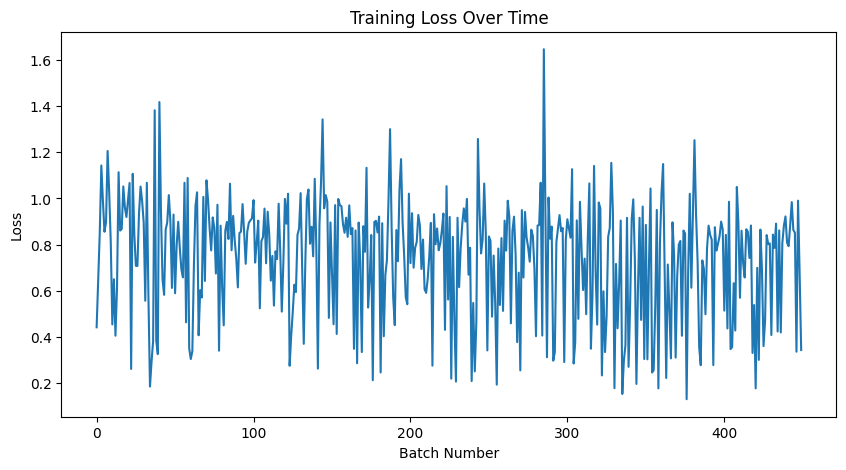

In [107]:
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')

plt.show()

Plot the logits difference

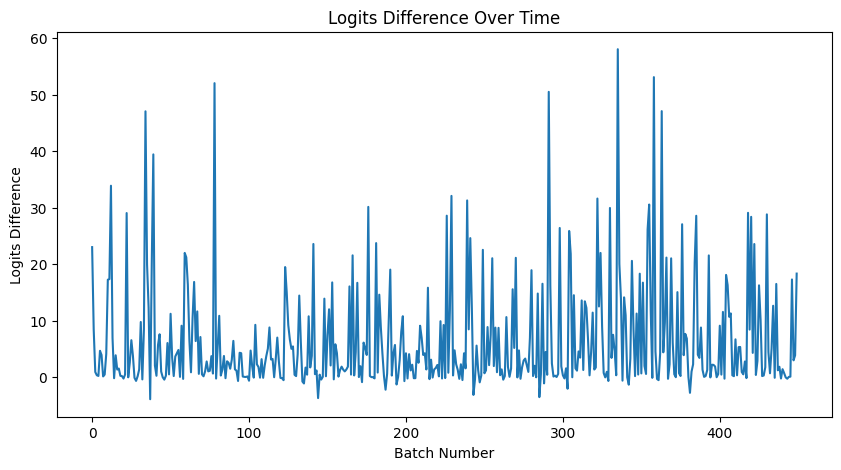

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(all_logits_diff, label='Logits Difference')
plt.xlabel('Batch Number')
plt.ylabel('Logits Difference')
plt.title('Logits Difference Over Time')

plt.show()

#### Evaluation [15 points]

Evaluating the model to see the fruits of our labour.

In [ ]:
def compute_accuracy(logits_diff):
    correct = (logits_diff > 0).sum().item()
    total = logits_diff.numel()
    return correct / total


In [ ]:
def evaluate_dpo_accuracy(model, loader, beta=0.1):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            chosen_inputs = tokenize_pairs(batch["prompt"], batch["chosen"])
            rejected_inputs = tokenize_pairs(batch["prompt"], batch["rejected"])
            
            for k in chosen_inputs:
                chosen_inputs[k] = chosen_inputs[k].to(device)
            for k in rejected_inputs:
                rejected_inputs[k] = rejected_inputs[k].to(device)
            
            logp_c = compute_logprob(
                model,
                chosen_inputs["input_ids"],
                chosen_inputs["attention_mask"]
            )
            logp_r = compute_logprob(
                model,
                rejected_inputs["input_ids"],
                rejected_inputs["attention_mask"]
            )
            
            diff = logp_c - logp_r
            correct += (diff > 0).sum().item()
            total += diff.numel()

    return correct / total

ref_acc = evaluate_dpo_accuracy(reference_model, test_loader)
policy_acc = evaluate_dpo_accuracy(policy_model, test_loader)

print(f"Reference Model Accuracy: {ref_acc * 100:.2f}%")
print(f"Policy Model Accuracy:    {policy_acc * 100:.2f}%")


Reference Model Accuracy: 52.00%
Policy Model Accuracy:    80.00%


Next, you must write code to show a few comparisons between the reference (baseline) and the policy model. Randomly sample 3 prompts from the test set and generate responses from both models.

In [ ]:
import random

random.seed(42)
num_samples = 3
indices = random.sample(range(len(test_data)), num_samples)

print("\n=== Sample Generation Comparisons ===\n")
for idx in indices:
    example = test_data[idx]
    prompt = example["prompt"]
    print(f"Prompt:\n{prompt}\n")

    inputs_ref = tokenizer(prompt, return_tensors="pt").to(device)
    inputs_pol = tokenizer(prompt, return_tensors="pt").to(device)

    ref_output = __generate(
        reference_model,
        {"input_ids": inputs_ref["input_ids"], "attention_mask": inputs_ref["attention_mask"]},
        num_tokens=50,
        tokenizer=tokenizer,
        max_length=50
    )
    pol_output = __generate(
        policy_model,
        {"input_ids": inputs_pol["input_ids"], "attention_mask": inputs_pol["attention_mask"]},
        num_tokens=50,
        tokenizer=tokenizer,
        max_length=50
    )

    print(f"Reference Model Output:\n{ref_output}\n")
    print(f"Policy Model Output:\n{pol_output}\n")
    print("-" * 80 + "\n")



=== Sample Generation Comparisons ===

Prompt:


Human: What is the best food city in the world?

Assistant: That’s a great question, and I’m not sure what the most extensive list of food cities is. But here’s a short list of three cities that I think are particularly famous for food.  They include Paris, Florence, and New Orleans.  All three of these cities are top tourist destinations, and they’re famous for their diverse, exquisite cuisine.  Of all three, New Orleans is probably the most famous for its unique region-specific cuisine, including a number of culinary specialties such as gumbo, po’boys, and crawfish étouffee. Florence is another popular destination for travelers, and its food is widely characterized by outstanding local ingredients and traditional recipes that date back centuries.  This is due to its influential culinary history, which includes it being the home of many formal, region-specific culinary techniques such as pasta making and bread-making.  Paris is one of 

Comment on your observations:

The reference outputs remain generally fluent and on-topic, whereas the policy responses often degrade into odd phrasing or incomplete thoughts. On fact-based questions (“What countries produce the most salt?”), both models list plausible answers, but the policy’s list (“United States, China, India, and France”) is correct yet its explanation is less polished.
Overall, the policy model sometimes echoes the right content, its outputs are still less reliable, less coherent, and occasionally nonsensical compared to the reference model.

#### Observations and Questions [10 points]

Q1. Comment on the difference between the accuracy of the policy model and that of the reference model. In the case of this assignment, state at least two factors that may be holding back the policy model from having an even higher accuracy. 

The accuracies show that the model has learned to rank chosen responses above rejected ones far more reliably than the original fine-tuned model. We only filtered down to 1 000 examples with heuristic rules, so the model sees a relatively small, potentially skewed data sample. By freezing most of the network, we may have starved the policy of the capacity it needs to fully separate chosen from rejected continuations.

Q2. What does the β parameter in DPO control? What might happen if it is set too high or too low?

β in DPO acts like a contrast strength or temperature for the preference margin. If β is set too low, the sigmoid becomes very flat around zero, so the loss barely distinguishes between good and bad pairs. If β is set too high , the sigmoid turns into a very sharp step function. Small fluctuations in the margin get amplified into huge loss changes, which can destabilize training.

Q3. What would happen if you mistakenly used the reference model's log-probs in place of the policy model during training?

If you accidentally plugged the reference model’s log-probs, since the loss no longer depends on any policy parameters, gradients will vanish and the policy will never learn to prefer chosen over rejected. The training loop would leanr nothing at all and the policy model would be based on random chance.

Q4. Suppose a batch contains a rejected response that is significantly longer than the chosen one. How might this affect training? How could you address this?

When your rejected response is much longer than the chosen one, you introduce a length bias into your DPO signal. A longer rejected response will tend to have a lower average log-prob because there are more tokens to multiply over. The model would also overfit to the length. To address it we can compute the log-prob metric as an average per token rather than a sum, drop or down-weight pairs whose length difference exceeds some threshold during preprocessing, or enforce a fixed max length for both chosen and rejected continuations.

Q5. Briefly explain one problem you ran into while training your model and explain how you solved it. This can be a small issue or a problem you needed to spend a lot of time to fix.

One of the biggest problems I ran into was that , the policy model would start spitting out gibberish, owed to catastrophic forgetting of its base LM skills. I traced it back to overly aggressive DPO updateson such a small dataset, so the model simply “unlearned” how to speak coherently.
TO fix it I introduced a small auxiliary LM‐CrossEntropy loss on the chosen continuations, dropped the LR to 5 × 10⁻⁵, and capped training at just 2–4 epochs.